In [1]:
import os
import sys
import igl
import subprocess
import numpy as np 
import shapeworks as sw
import meshplot as mp
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from sklearn.decomposition import PCA
from ipywidgets import interact, widgets

sys.path.append('../../utils/')
from sap_score import sap

## Left hippocampi meshes

In [2]:
mesh_list = []

for mesh_path in tqdm(sorted(glob("groomed/meshes/data/*left.vtk"))):
    mesh = sw.Mesh(mesh_path)
    mesh_list.append(mesh)

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:36<00:00, 14.08it/s]


## Right hippocampi meshes

In [3]:
right_mesh_list = []

for mesh_path in tqdm(sorted(glob("groomed/meshes/data/*right.vtk"))):
    mesh = sw.Mesh(mesh_path)
    right_mesh_list.append(mesh)

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:37<00:00, 13.76it/s]


## Left hippocampi particles

In [4]:
particle_list = []

for particles_path in tqdm(sorted(glob("shape_model/hippocampus_particles/*left_world.particles"))):
    particles = sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)
    particle_list.append(particles.flatten())

particles_array = np.array(particle_list)

100%|████████████████████████████████████████████████████████████████████████████| 511/511 [00:05<00:00, 98.02it/s]


## Right hippocampi particles

In [5]:
right_particle_list = []

for particles_path in tqdm(sorted(glob("shape_model/hippocampus_particles/*right_world.particles"))):
    particles = sw.ParticleSystem([particles_path]).ShapeAsPointSet(0)
    right_particle_list.append(particles.flatten())

right_particles_array = np.array(right_particle_list)

100%|███████████████████████████████████████████████████████████████████████████| 511/511 [00:04<00:00, 103.55it/s]


## Left hippocampi PCA

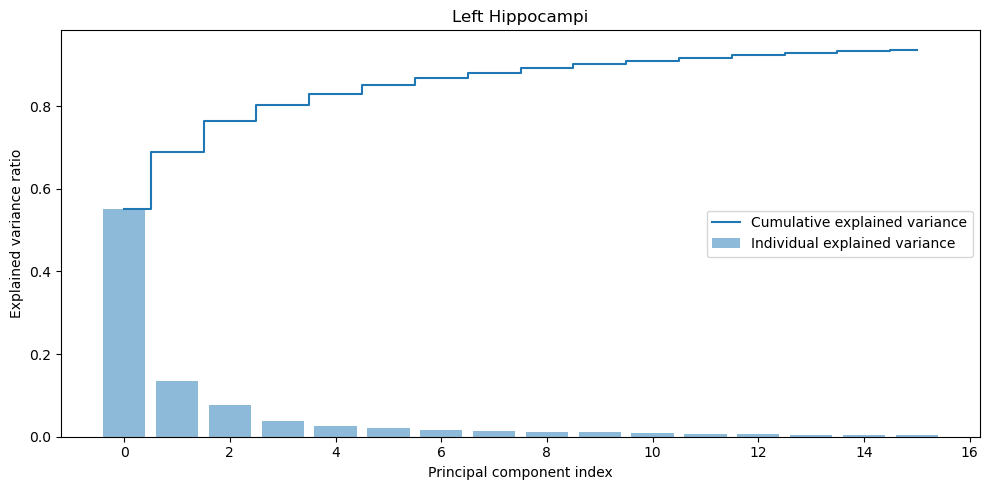

In [6]:
pca = PCA(n_components=16)
pca.fit(particles_array)
pca_latent = pca.transform(particles_array)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.figure(figsize=(10,5))
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.title("Left Hippocampi")
plt.tight_layout()
plt.savefig("figures/left_hippo.png")
plt.show()

## Right hippocampi PCA

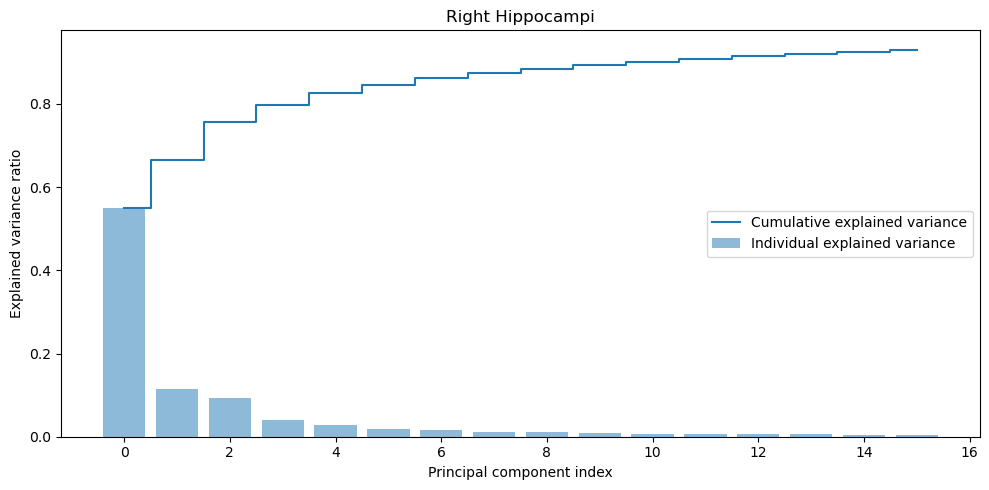

In [7]:
right_pca = PCA(n_components=16)
right_pca.fit(right_particles_array)
right_pca_latent = right_pca.transform(right_particles_array)

right_exp_var_pca = right_pca.explained_variance_ratio_
right_cum_sum_eigenvalues = np.cumsum(right_exp_var_pca)

plt.figure(figsize=(10,5))
plt.bar(range(0,len(right_exp_var_pca)), right_exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(right_cum_sum_eigenvalues)), right_cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='center right')
plt.title("Right Hippocampi")
plt.tight_layout()
plt.savefig("figures/right_hippo.png")
plt.show()

## Latent traversal

In [8]:
maps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
shading = {"colormap": maps[2]}

In [13]:
hippo_shape = 0

#left
original_mesh = mesh_list[hippo_shape]
particles = sorted(glob("shape_model/hippocampus_particles/*left_local.particles"))
original_particles = sw.ParticleSystem([particles[hippo_shape]]).ShapeAsPointSet(0)

#right
right_original_mesh = right_mesh_list[hippo_shape]
right_particles = sorted(glob("shape_model/hippocampus_particles/*right_local.particles"))
right_original_particles = sw.ParticleSystem([right_particles[hippo_shape]]).ShapeAsPointSet(0)

#left
warper = sw.MeshWarper()
warper.generateWarp(original_mesh, original_particles)
warped_mesh = warper.buildMesh(original_particles)

#right
right_warper = sw.MeshWarper()
right_warper.generateWarp(right_original_mesh, right_original_particles)
right_warped_mesh = right_warper.buildMesh(right_original_particles)

p = mp.plot(warped_mesh.points(), warped_mesh.faces(), shading=shading)
p.add_mesh(right_warped_mesh.points(), right_warped_mesh.faces(), shading=shading)

std_0 = pca_latent[:,0].std()
std_1 = pca_latent[:,1].std()
std_2 = pca_latent[:,2].std()
std_3 = pca_latent[:,3].std()

@interact(z0=widgets.FloatSlider(value=pca_latent[hippo_shape][0], min=-2.5*std_0, max=2.5*std_0, step=0.01),
          z1=widgets.FloatSlider(value=pca_latent[hippo_shape][1], min=-2.5*std_1, max=2.5*std_1, step=0.01),
          z2=widgets.FloatSlider(value=pca_latent[hippo_shape][2], min=-2.5*std_2, max=2.5*std_2, step=0.01),
          z3=widgets.FloatSlider(value=pca_latent[hippo_shape][3], min=-2.5*std_3, max=2.5*std_3, step=0.01))
def visualize(z0, z1, z2, z3):
    latent_code = pca_latent[hippo_shape]
    right_latent_code = right_pca_latent[hippo_shape]
    
    #left
    latent_code[0] = z0
    latent_code[1] = z1
    latent_code[2] = z2
    latent_code[3] = z3
    
    #right
    right_latent_code[0] = -z0
    right_latent_code[1] = z1
    right_latent_code[2] = z2
    right_latent_code[3] = z3
    
    #left
    recon_particles = pca.inverse_transform(latent_code).reshape(-1,3)
    recon_mesh = warper.buildMesh(recon_particles)
    
    #right
    right_recon_particles = right_pca.inverse_transform(right_latent_code).reshape(-1,3)
    right_recon_mesh = right_warper.buildMesh(right_recon_particles)
    
    #left
    diff = warped_mesh.points() - recon_mesh.points()
    dist = np.linalg.norm(diff, axis=1)
    
    #left
    right_diff = right_warped_mesh.points() - right_recon_mesh.points()
    right_dist = np.linalg.norm(right_diff, axis=1)
    
    #left
    p.update_object(oid=0, vertices=recon_mesh.points(), colors=dist)
    
    #right
    p.update_object(oid=1, vertices=right_recon_mesh.points(), colors=right_dist)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(89.228321…

interactive(children=(FloatSlider(value=-54.94605193648047, description='z0', max=117.37036920321438, min=-117…